<a href="https://colab.research.google.com/github/datakind/Viamo_DataDive_Dec22/blob/main/Workstream%20%232/Viamo_Workstream2_Mali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Install and import packages**

In [102]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

In [ ]:
!pip install google-cloud
!pip install google-cloud-bigquery[pandas]
!pip install google-cloud-storage
!pip install pandas-gbq -U

In [2]:
from google.cloud import bigquery

##**Initial setup**

I'm going to extract only 100,000 rows for organization_country equal to 'Mali'. Only columns that are deemed relevant will be extracted here. 

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'viamo-datakind-19b12e3872f5.json'

Bigquery_client = bigquery.Client()

df = pd.read_gbq("SELECT call_id, call_date, subscriber_id, call_started, call_ended, region, region_name, age, gender, location, location_level_2, subscriber_pereferred_language, rural_or_urban, phone_type, education_level, income_source, highest_expense_area, duration_listened_minutes, duration_listened_seconds FROM `viamo-datakind.datadive.321_sessions_1122` WHERE organization_country='Mali' ORDER BY RAND() LIMIT 100000")

##**Take a quick look at the data: EDA and some data cleaning**

I want to say this before I forget: it seems like there's a mispelled column [subscriber_pereferred_language], where 'preferred' is spelled wrongly. Not a big deal though

In [7]:
df.head()

,call_id,call_date,subscriber_id,call_started,call_ended,region,region_name,age,gender,location,location_level_2,subscriber_pereferred_language,rural_or_urban,phone_type,education_level,income_source,highest_expense_area,duration_listened_minutes,duration_listened_seconds
0,1237923650804969120,2021-05-09,975164437751717888,2021-05-09 00:26:37+00:00,2021-05-09 00:37:20+00:00,FWA,Francophone West Africa,None,female,Kayes,Cercle de Bafoulabé,Bambara,None,None,None,None,None,0.1,3.0
1,1329132350051249928,2022-01-15,1045380879683739648,2022-01-15 16:57:26+00:00,2022-01-15 17:02:28+00:00,FWA,Francophone West Africa,25_34,male,Koulikoro,Cercle de Dioïla,Bambara,None,None,None,None,None,0.4,25.0
2,1264693588106207632,2021-07-21,1137671860017225728,2021-07-21 21:20:48+00:00,2021-07-21 21:22:55+00:00,FWA,Francophone West Africa,25_34,male,Gao,Cercle de Menaka,Tamasheq,None,None,None,None,None,0.4,24.0
3,1313133532499471944,2021-12-02,1303034504025793892,2021-12-02 13:23:50+00:00,2021-12-02 13:30:16+00:00,FWA,Francophone West Africa,None,None,None,None,Bambara,None,None,None,None,None,0.0,0.0
4,1361662687444527780,2022-04-15,1357416466106344116,2022-04-15 11:21:23+00:00,2022-04-15 11:46:57+00:00,FWA,Francophone West Africa,under_18,male,Kidal,Cercle de Abeïbara,Fula,None,None,None,None,None,1.3,77.0


###**Missing data**

In [9]:
df.isnull().sum()

call_id                                0
call_date                              0
subscriber_id                          0
call_started                           0
call_ended                             0
region                                 0
region_name                            0
age                                25867
gender                             14942
location                           17745
location_level_2                   34856
subscriber_pereferred_language       562
rural_or_urban                    100000
phone_type                        100000
education_level                   100000
income_source                     100000
highest_expense_area              100000
duration_listened_minutes           1020
duration_listened_seconds           1020
dtype: int64

We can see that all the rows extracted don't have values for these columns: [rural_or_urban], [phone_type], [education_level], [income_source], and [highest_expense_area]. I am going to remove these columns.

In [11]:
df = df.drop(columns=['rural_or_urban', 'phone_type', 'education_level', 'income_source', 'highest_expense_area'])
df.isnull().sum()

call_id                               0
call_date                             0
subscriber_id                         0
call_started                          0
call_ended                            0
region                                0
region_name                           0
age                               25867
gender                            14942
location                          17745
location_level_2                  34856
subscriber_pereferred_language      562
duration_listened_minutes          1020
duration_listened_seconds          1020
dtype: int64

Since I'm only going to visualize this data and not run some machine learning algorithm on it, I feel like it's ok to have some null data in some of these columns, so I will keep them for now!

###**Outliers**

In [12]:
df.describe()

,call_id,subscriber_id,duration_listened_minutes,duration_listened_seconds
count,1.000000e+05,1.000000e+05,98980.000000,98980.000000
mean,1.843820e+13,6.388066e+13,0.957700,57.418236
std,6.919553e+16,1.341801e+17,2.303347,138.163703
min,1.191540e+18,7.322052e+17,0.000000,0.000000
25%,1.255619e+18,1.017540e+18,0.000000,2.000000
50%,1.312043e+18,1.113248e+18,0.200000,14.000000
75%,1.368935e+18,1.259061e+18,0.900000,52.000000
max,1.441573e+18,1.441363e+18,45.500000,2728.000000


Someone listened for 45.5 minutes but the third quartile is only 0.9 minutes. 

Again, since I'm only going to visualize this data and not run some machine learning algorithm on it so I'm going to keep these potential outliers for now.

###**Repetitive or uninformative data**

In [18]:
df[['region', 'region_name']].apply(pd.Series.value_counts)

,region,region_name
FWA,100000.0,NaN
Francophone West Africa,NaN,100000.0


It seems like all the values in the [region] and [region_name] columns are the same respectively, so I will remove these columns.

In [22]:
df = df.drop(columns=['region', 'region_name'])

In [19]:
df['location'].value_counts()

Sikasso       21305
Segou         14698
Kayes         13598
Koulikoro     10512
Mopti          8553
Bamako         5490
Tombouctou     3768
Kidal          2362
Gao            1956
Ségou             3
Koutiala          2
Bankass           1
Fana              1
Kita              1
Banamba           1
SÃ©gou            1
Kati              1
Sagabary          1
Bougouni          1
Name: location, dtype: int64

In [20]:
df['location_level_2'].value_counts()

Cercle de Bougouni          6585
Cercle de Kadiolo           3871
Cercle de Barouéli          3341
Cercle de Koutiala          3145
Cercle de Bafoulabé         3013
Cercle de Bla               2930
Cercle de Kéniéba           2854
Cercle de Diéma             2572
Cercle de Banamba           2396
Cercle de Dioïla            2387
Cercle de Sikasso           2338
Cercle de Bandiagara        2179
Cercle de Macina            1937
Cercle de Bankass           1547
Cercle de Niono             1427
Cercle de Ségou             1329
Cercle de Kita              1233
Cercle de Kayes             1223
Cercle de Goundam           1182
Cercle de Djenné            1169
Cercle de Kangaba           1047
Cercle de Kati              1004
Cercle de San                987
Cercle de Kolondiéba         856
Cercle de Gao                786
Cercle de Kolokani           763
Cercle de Yorosso            757
Cercle de Mopti              757
Cercle de Koulikoro          752
Cercle de Kidal              749
Cercle de 

In [21]:
df['subscriber_pereferred_language'].value_counts()

Bambara     70451
Fula        13232
Tamasheq     6813
Songhay      5041
French       3901
Name: subscriber_pereferred_language, dtype: int64

[location], [location_level_2], and [subscriber_pereferred_language] look ok.

###**Duplicates**

Let's remove any duplicate rows.

In [28]:
df[df.duplicated()]

,call_id,call_date,subscriber_id,call_started,call_ended,age,gender,location,location_level_2,subscriber_pereferred_language,duration_listened_minutes,duration_listened_seconds
41804,1313788982043668336,2021-12-04,1304885393766280008,2021-12-04 08:48:22+00:00,2021-12-04 09:33:12+00:00,None,None,None,None,Tamasheq,1.2,73.0
46187,1349785289581191804,2022-03-13,1127948180878057473,2022-03-13 16:44:50+00:00,2022-03-13 19:44:51+00:00,over_44,male,Sikasso,Cercle de Bougouni,Tamasheq,2.0,118.0
70169,1311155533159917708,2021-11-27,1311154939108059044,2021-11-27 02:23:59+00:00,2021-11-27 04:57:38+00:00,None,None,None,None,Fula,1.6,96.0


It seems like these 3 rows have duplicates somewhere in the dataframe. I'm going to remove their duplicates.

In [29]:
df = df.drop_duplicates()
df.shape

(99997, 12)

3 rows are removed from the dataframe.

###**Data types**

In [30]:
df.dtypes

call_id                                         Int64
call_date                                      dbdate
subscriber_id                                   Int64
call_started                      datetime64[ns, UTC]
call_ended                        datetime64[ns, UTC]
age                                            object
gender                                         object
location                                       object
location_level_2                               object
subscriber_pereferred_language                 object
duration_listened_minutes                     float64
duration_listened_seconds                     float64
dtype: object

Matplotlib needs the date to be in datetime64[ns]. Change the call_date column's data type to datetime64[ns].

In [54]:
df.call_date = pd.to_datetime(df.call_date, format="%Y-%m-%d")

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [55]:
df.dtypes

call_id                                         Int64
call_date                              datetime64[ns]
subscriber_id                                   Int64
call_started                      datetime64[ns, UTC]
call_ended                        datetime64[ns, UTC]
age                                            object
gender                                         object
location                                       object
location_level_2                               object
subscriber_pereferred_language                 object
duration_listened_minutes                     float64
duration_listened_seconds                     float64
dtype: object

The data types for other columns look ok.

##**Workstream 2: Bivariate Data Exploration**

###**Question 15: Distribution of calls (unique call ids) over time (day, week, month)**

In [96]:
day_calls_df = df[['call_date', 'call_id']].copy()
day_calls_df = day_calls_df.drop_duplicates()

In [107]:
day_calls_df.call_date.nunique()

690

I'm going to set the number of bins to 690 so that each bin will have only 1 day.

In [109]:
day_calls_df.call_date.describe()

<ipython-input-109-fb2938c24c0b>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                   99900
unique                    690
top       2021-11-19 00:00:00
freq                      235
first     2021-01-01 00:00:00
last      2022-11-21 00:00:00
Name: call_date, dtype: object

From the data above, we can see that 2021-11-29 got the most unique calls (235 calls in total). The earliest date we have here is 2021-01-01 and the latest one is 2022-11-21.

In [108]:
fig = px.histogram(day_calls_df, x='call_date', nbins=690)
fig.show()

Hover over the graph above to see the exact count on each day. If the Plotly graph above is not preferred, here's a Matplotlib version:

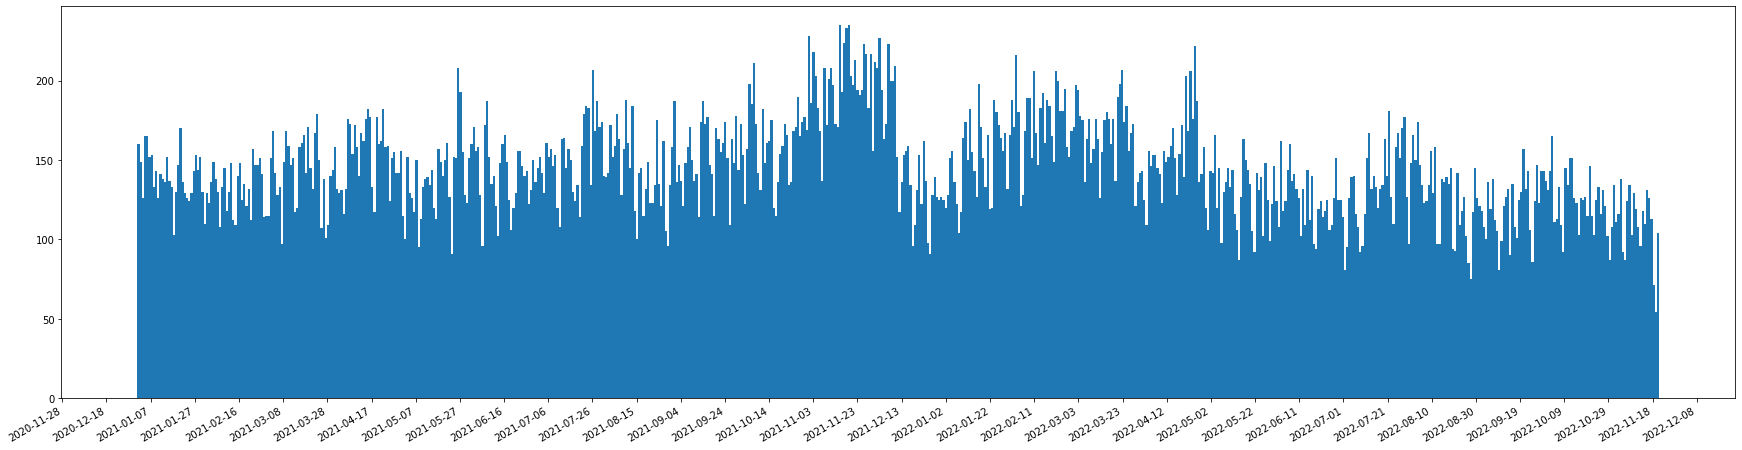

In [130]:
import matplotlib.dates as mdates
plt.figure(figsize=(30,8))
plt.hist(day_calls_df.call_date, bins=690)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()